In [1]:
import pandas as pd
import re
import numpy as np
from scipy import stats
import scipy as sp
from sklearn import metrics

import os
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.precision', 4)

In [2]:
def score_col_splitter(X, score_col):

    quarter = score_col.split("_")[0]
    
    X['Home_Score'] = X[score_col].apply(lambda x: x.split(" - ")[0].split(".")[-1]).astype(int)
    X['Home_Goals'] = X[score_col].apply(lambda x: x.split(" - ")[0].split(".")[0]).astype(int)
    X['Home_Behinds'] = X[score_col].apply(lambda x: x.split(" - ")[0].split(".")[1]).astype(int)
    X['Home_Shots'] = X['Home_Goals'] + X['Home_Behinds']
    X['Home_Conversion'] = X['Home_Goals'] / X['Home_Shots']
    
    X['Away_Score'] = X[score_col].apply(lambda x: x.split(" - ")[1].split(".")[-1]).astype(int)
    X['Away_Goals'] = X[score_col].apply(lambda x: x.split(" - ")[1].split(".")[0]).astype(int)
    X['Away_Behinds'] = X[score_col].apply(lambda x: x.split(" - ")[1].split(".")[1]).astype(int)
    X['Away_Shots'] = X['Away_Goals'] + X['Away_Behinds']
    X['Away_Conversion'] = X['Away_Goals'] / X['Away_Shots']
        
    return X

Load Match Summary Data

In [3]:
match_summary = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/data/match_summary.csv")
match_summary = score_col_splitter(match_summary, "Q4_Score")
match_summary['Season'] = match_summary['Match_ID'].apply(lambda x: int(x[:4]))
match_summary.head()

,Home_Team,Away_Team,Q4_Score,Margin,Total Game Score,Home Win,Venue,City,Date,Attendance,Temperature,Weather_Type,Year,Round_ID,Match_ID,Season,Home_Score,Home_Goals,Home_Behinds,Home_Shots,Home_Conversion,Away_Score,Away_Goals,Away_Behinds,Away_Shots,Away_Conversion
0,Brisbane Lions,Sydney,14.10.94 - 19.11.125,-31,219,0.0,Gabba,Brisbane,2021-03-20 19:45:00,0,18,MOSTLY_SUNNY,2021,202101,202101_BrisbaneLions_Sydney,2021,94,14,10,24,0.5833,125,19,11,30,0.6333
1,Collingwood,Western Bulldogs,7.11.53 - 10.9.69,-16,122,0.0,M.C.G.,Melbourne,2021-03-19 19:50:00,0,27,MOSTLY_SUNNY,2021,202101,202101_Collingwood_WesternBulldogs,2021,53,7,11,18,0.3889,69,10,9,19,0.5263
2,Essendon,Hawthorn,13.13.91 - 14.8.92,-1,183,0.0,Docklands,Melbourne,2021-03-20 19:25:00,0,26,MOSTLY_SUNNY,2021,202101,202101_Essendon_Hawthorn,2021,91,13,13,26,0.5000,92,14,8,22,0.6364
3,Greater Western Sydney,St Kilda,11.12.78 - 13.8.86,-8,164,0.0,Sydney Showground,Sydney,2021-03-21 15:20:00,0,22,RAIN,2021,202101,202101_GreaterWesternSydney_StKilda,2021,78,11,12,23,0.4783,86,13,8,21,0.6190
4,Melbourne,Fremantle,11.14.80 - 8.10.58,22,138,1.0,M.C.G.,Melbourne,2021-03-20 13:45:00,0,26,MOSTLY_SUNNY,2021,202101,202101_Melbourne_Fremantle,2021,80,11,14,25,0.4400,58,8,10,18,0.4444


Load Player Stats Data

In [4]:
player_stats = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/data/scored_player_stats.csv")
player_stats['Season'] = player_stats['Match_ID'].apply(lambda x: int(x[:4]))
player_stats['Player_Season'] = player_stats['Player'] + "_" + player_stats['Season'].astype(str)

player_stats['Score'] = player_stats['Behinds'] + player_stats['Goals']*6
player_stats['xScore_Diff'] = player_stats['Score'] - player_stats['xScore']

player_stats['Home_Team'] = player_stats['Match_ID'].apply(lambda x: x.split("_")[1]).str.replace(r"([A-Z])", r" \1").str.strip()
player_stats['Away_Team'] = player_stats['Match_ID'].apply(lambda x: x.split("_")[-1]).str.replace(r"([A-Z])", r" \1").str.strip()
player_stats['Opponent'] = np.where(player_stats['Team'] == player_stats['Home_Team'], player_stats['Away_Team'], player_stats['Home_Team'])

finals_round_map = {'F1':24,
                    'F2':25,
                    'F3':26,
                    'F4':27}
player_stats['Round_ID'] = player_stats['Round_ID'].astype(str)
player_stats['Round'] = (player_stats['Round_ID'].str[4:].replace(finals_round_map)).astype(int)
player_stats['Round_str'] = player_stats['Round_ID'].str[4:].replace(finals_round_map)
player_stats['Round_ID_num'] = (player_stats['Season'].astype(str) + player_stats['Round'].astype(str)).astype(int)

player_stats.tail()

,Match_ID,Team,Player,Round_ID,AFL_API_Player_ID,Player_Type,playerId,Age,Height,Weight,Number,Kicking_Foot,State_Of_Origin,Draft_Year,Debut_Year,Recruited_From,Draft_Position,Draft_Type,Photo_URL,Date_Of_Birth,Percent_Played,Behinds,Bounces,Centre_Bounces_Attended,Centre_Clearances,Clangers,Defensive_Contest_Losses,Defensive_Contest_Loss_Percentage,Defensive_One_On_One_Contests,Contested_Marks,Contested_Possession_Rate,Contested_Possessions,Offensive_One_On_One_Contests,Offensive_Contest_Wins,Offensive_Contest_Win_Percentage,Defensive_Half_Pressure_Acts,Disposal_Efficiency,Disposals,AFL_Fantasy_Points,Effective_Disposals,Effective_Kicks,Inside_50_Ground_Ball_Gets,Frees_Against,Frees_For,Goal_Accuracy,Goal_Assists,Goals,Ground_Ball_Gets,Handballs,Hit_Outs,Hit_Outs_To_Advantage,Hit_Outs_To_Advantage_Rate,Hit_Out_Win_Percentage,Inside_50s,Intercept_Marks,Intercepts,Kick_Efficiency,Kick_Ins,Kick_Ins_Played_On,Kicks,Kick_To_Handball_Ratio,Marks,Marks_Inside_50,Marks_On_Lead,Metres_Gained,One_Percenters,Pressure_Acts,Player_Rating_Points,Rebound_50s,Ruck_Contests,Score_Involvements,Score_Launches,Shots_At_Goal,Spoils,Stoppage_Clearances,Tackles,Tackles_Inside_50,Clearances,Possessions,Turnovers,Uncontested_Possessions,AFLCA_Player_ID,Coaches_Votes,Position,Team_Status,Position_Sub_Group,Position_Group,Year,Brownlow_Votes,Season,xScore,xT_created,xT_denied,vaep_value,offensive_value,defensive_value,exp_vaep_value,exp_offensive_value,exp_defensive_value,xT_received,xT_prevented,vaep_value_received,exp_vaep_value_received,Player_Season,Score,xScore_Diff,Home_Team,Away_Team,Opponent,Round,Round_str,Round_ID_num
27846,202323_WesternBulldogs_WestCoast,Western Bulldogs,Oskar Baker,202323,Oskar_Baker,MIDFIELDER,CD_I1008855,25,184,87,13,RIGHT,QLD,2017.0,2019.0,Wilston Grange (Qld)/Aspley (NEAFL)/Melbourne,48.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1998-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Half Forward Flank Right,FINAL_TEAM,Half-Forward,Forward,NaN,NaN,2023,7.9598,-0.3226,0.0167,0.3991,0.7006,-0.3015,2.8523,3.8194,-0.9671,-0.3267,0.0713,1.0483,3.4625,Oskar Baker_2023,NaN,NaN,Western Bulldogs,West Coast,West Coast,23,23,202323
27847,202323_WesternBulldogs_WestCoast,Western Bulldogs,Rhylee West,202323,Rhylee_West,MEDIUM_FORWARD,CD_I1006127,23,183,82,14,RIGHT,VIC,2018.0,2019.0,Strathmore (Vic)/St Kevin&apos;s College (Vic)...,26.0,fatherSon,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,2000-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Forward Pocket Right,FINAL_TEAM,Forward-Pocket,Forward,NaN,NaN,2023,9.7706,0.1389,0.0000,0.5694,0.6452,-0.0758,7.0749,7.4761,-0.4012,0.4868,0.0043,0.9269,6.2204,Rhylee West_2023,NaN,NaN,Western Bulldogs,West Coast,West Coast,23,23,202323
27848,202323_WesternBulldogs_WestCoast,Western Bulldogs,Rory Lobb,202323,Rory_Lobb,KEY_FORWARD,CD_I990740,30,207,106,7,RIGHT,WA,2013.0,2014.0,Bassendean (WA)/Swan Districts (WAFL)/GWS/Frem...,29.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1993-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Forward Pocket Left,FINAL_TEAM,Forward-Pocket,Forward,NaN,NaN,2023,17.1166,-0.1439,-0.0025,1.7295,1.8518,-0.1224,11.1693,12.7523,-1.5830,0.4878,-0.0002,1.1501,10.5511,Rory Lobb_2023,NaN,NaN,Western Bulldogs,West Coast,West Coast,23,23,202323
27849,202323_WesternBulldogs_WestCoast,Western Bulldogs,Taylor Duryea,

Create Match Level Expected Data from Player Stats

In [5]:
match_stats = player_stats.groupby(['Match_ID', 'Team', 'Home_Team']).sum()[['Score', 'xScore', 'vaep_value', 'offensive_value', 'defensive_value', 'exp_vaep_value', 'exp_offensive_value', 'exp_defensive_value']].reset_index()
match_stats['Home_Away'] = np.where(match_stats['Team'] == match_stats['Home_Team'], 'Home', 'Away')
match_stats = match_stats.pivot(index = 'Match_ID', columns = 'Home_Away', values = ['xScore', 'vaep_value', 'offensive_value', 'defensive_value', 'exp_vaep_value', 'exp_offensive_value', 'exp_defensive_value'])
match_stats.columns = ['_'.join((y, x)) for (x, y) in match_stats.columns]
match_stats.head()

,Away_xScore,Home_xScore,Away_vaep_value,Home_vaep_value,Away_offensive_value,Home_offensive_value,Away_defensive_value,Home_defensive_value,Away_exp_vaep_value,Home_exp_vaep_value,Away_exp_offensive_value,Home_exp_offensive_value,Away_exp_defensive_value,Home_exp_defensive_value
Match_ID,,,,,,,,,,,,,,
202101_BrisbaneLions_Sydney,92.4685,69.7281,24.2606,19.2363,22.3104,16.3960,1.9501,2.8403,121.0789,100.5702,114.2657,87.4443,6.8132,13.1260
202101_Collingwood_WesternBulldogs,89.9581,60.3994,15.9335,13.9565,13.1114,10.0669,2.8221,3.8897,126.5315,99.6866,112.0616,84.0031,14.4699,15.6836
202101_Essendon_Hawthorn,90.4045,93.4030,21.0892,20.2102,18.6803,15.8776,2.4089,4.3326,117.6707,118.2525,109.9257,105.5508,7.7450,12.7016
202101_GreaterWesternSydney_StKilda,80.1441,92.1888,20.6573,18.4181,16.8530,15.0227,3.8042,3.3954,111.5834,127.2029,104.5752,109.8564,7.0082,17.3465
202101_Melbourne_Fremantle,68.4989,98.1589,12.3997,14.5982,10.7470,11.9639,1.6527,2.6343,85.5965,115.5518,83.4532,106.5428,2.1433,9.0090


Merge Match Summary and Stats Data

In [6]:
match_summary_stats = match_summary.merge(match_stats, how = "left", on = "Match_ID")

In [7]:
match_summary_stats.head()

,Home_Team,Away_Team,Q4_Score,Margin,Total Game Score,Home Win,Venue,City,Date,Attendance,Temperature,Weather_Type,Year,Round_ID,Match_ID,Season,Home_Score,Home_Goals,Home_Behinds,Home_Shots,Home_Conversion,Away_Score,Away_Goals,Away_Behinds,Away_Shots,Away_Conversion,Away_xScore,Home_xScore,Away_vaep_value,Home_vaep_value,Away_offensive_value,Home_offensive_value,Away_defensive_value,Home_defensive_value,Away_exp_vaep_value,Home_exp_vaep_value,Away_exp_offensive_value,Home_exp_offensive_value,Away_exp_defensive_value,Home_exp_defensive_value
0,Brisbane Lions,Sydney,14.10.94 - 19.11.125,-31,219,0.0,Gabba,Brisbane,2021-03-20 19:45:00,0,18,MOSTLY_SUNNY,2021,202101,202101_BrisbaneLions_Sydney,2021,94,14,10,24,0.5833,125,19,11,30,0.6333,92.4685,69.7281,24.2606,19.2363,22.3104,16.3960,1.9501,2.8403,121.0789,100.5702,114.2657,87.4443,6.8132,13.1260
1,Collingwood,Western Bulldogs,7.11.53 - 10.9.69,-16,122,0.0,M.C.G.,Melbourne,2021-03-19 19:50:00,0,27,MOSTLY_SUNNY,2021,202101,202101_Collingwood_WesternBulldogs,2021,53,7,11,18,0.3889,69,10,9,19,0.5263,89.9581,60.3994,15.9335,13.9565,13.1114,10.0669,2.8221,3.8897,126.5315,99.6866,112.0616,84.0031,14.4699,15.6836
2,Essendon,Hawthorn,13.13.91 - 14.8.92,-1,183,0.0,Docklands,Melbourne,2021-03-20 19:25:00,0,26,MOSTLY_SUNNY,2021,202101,202101_Essendon_Hawthorn,2021,91,13,13,26,0.5000,92,14,8,22,0.6364,90.4045,93.4030,21.0892,20.2102,18.6803,15.8776,2.4089,4.3326,117.6707,118.2525,109.9257,105.5508,7.7450,12.7016
3,Greater Western Sydney,St Kilda,11.12.78 - 13.8.86,-8,164,0.0,Sydney Showground,Sydney,2021-03-21 15:20:00,0,22,RAIN,2021,202101,202101_GreaterWesternSydney_StKilda,2021,78,11,12,23,0.4783,86,13,8,21,0.6190,80.1441,92.1888,20.6573,18.4181,16.8530,15.0227,3.8042,3.3954,111.5834,127.2029,104.5752,109.8564,7.0082,17.3465
4,Melbourne,Fremantle,11.14.80 - 8.10.58,22,138,1.0,M.C.G.,Melbourne,2021-03-20 13:45:00,0,26,MOSTLY_SUNNY,2021,202101,202101_Melbourne_Fremantle,2021,80,11,14,25,0.4400,58,8,10,18,0.4444,68.4989,98.1589,12.3997,14.5982,10.7470,11.9639,1.6527,2.6343,85.5965,115.5518,83.4532,106.5428,2.1433,9.0090


Home Advantage

In [8]:
match_summary_stats['Home Win'].mean()

0.5683690280065898

In [9]:
match_summary_stats.groupby('Season').mean()['Home Win']

Season
2021    0.5218
2022    0.6014
2023    0.5825
Name: Home Win, dtype: float64

In [10]:
match_summary_stats.groupby('Home Win').mean()['Margin'].sum()

4.311273679694736

In [11]:
match_summary_stats.groupby(['Season', 'Home Win']).mean()['Margin'].groupby('Season').sum()

Season
2021     6.4198
2022    -3.6583
2023    10.4268
Name: Margin, dtype: float64

In [12]:
starting_home_advantage = match_summary_stats[match_summary_stats['Season']==2021]['Home Win'].mean() / 0.5
starting_home_advantage

1.0436893203883495

In [13]:
match_summary_stats[match_summary_stats['Season']==2021][['Home_exp_vaep_value', 'Away_exp_vaep_value']].mean()


Home_exp_vaep_value    112.7810
Away_exp_vaep_value    108.4492
dtype: float64

In [14]:
match_summary_stats[match_summary_stats['Season']==2021][['Home_exp_offensive_value', 'Away_exp_offensive_value']].mean()

Home_exp_offensive_value    100.8456
Away_exp_offensive_value     97.5022
dtype: float64

In [15]:
match_summary_stats[match_summary_stats['Season']==2021][['Home_exp_defensive_value', 'Away_exp_defensive_value']].mean()

Home_exp_defensive_value    11.9354
Away_exp_defensive_value    10.9471
dtype: float64

Team Ratings

Team Ratings are going to be normally distributed, around some mean value with a standard deviation (average rating and confidence/variance in that rating/future performance.)

Team ratings should not account for Home advantage, but should get updated compared to their pre-match expectations. (Bayesian update)

Team performances will be the team rating + some home advantage modifier + consideration of opposition team rating and will be normally distributed.

Team Ratings are based on Expected VAEP Values for each match by a team, the HA-neutralised ones.

Team Ratings highly depend on the individual Player Ratings that are playing for that team in that match.
Ideally Team Ratings are the sum of individual Player Ratings.

Player Ratings are normally distributed, around some mean value with a standard deviation (average rating and variance in performance).

Player ratings should not account for Home advantage, but should get updated compared to their pre-match expectations. (Bayesian update)

Player performances will be the Player rating + some home advantage modifier + consideration of opposition team rating and will be normally distributed.

Player Ratings are based on Expected Vaep Values for each match by a player. These will be scaled/proportioned into the HA-neutralised Expected Score of the team.



- Individual player ratings based on past Expected VAEP values
- Team ratings are the combined player ratings for whoever is playing
- Home advantage is some multiplier/adjustment that is applied to home/away team
- Predicted match outcome, probability, margin is based on both team's ratings
- Match happens
- Actual match outcome, margin is available
- Expected VAEP values for each player is available for latest game
- Player ratings are updated based on their Expected VAEP in the match compared to their prior Expected VAEP (HA-neutral)
- Team ratings are (either) updated based on new player ratings (or) updated based on actual margin compared to predicted margin (HA-neutral)

Player Values

In [172]:
starting_player_values = player_stats[player_stats['Season'] == 2021].groupby(['Player', 'Team']).mean()[['exp_vaep_value']].reset_index()
starting_player_values['exp_vaep_value'] = 0
# starting_player_values.sort_values(by = 'exp_vaep_value',ascending = False).head(10)

In [173]:
starting_player_stds = player_stats[player_stats['Season'] == 2021].groupby('Player').std()[['exp_vaep_value']].reset_index()
starting_player_stds.columns = ['Player', 'exp_vaep_value_std']
starting_player_stds['exp_vaep_value_std'] = 10
# starting_player_stds.sort_values(by = 'exp_vaep_value_std', ascending = False).head(10)

Match Level Player Ratings & Team Ratings

In [174]:
match_id = "202101_BrisbaneLions_Sydney"

In [175]:
match_player_stats = player_stats[player_stats['Match_ID'] == match_id]

In [176]:
home_players = list(match_player_stats[match_player_stats['Team'] == match_player_stats['Home_Team']]['Player'].unique())
away_players = list(match_player_stats[match_player_stats['Team'] != match_player_stats['Home_Team']]['Player'].unique())

In [177]:
home_rating = starting_player_values[starting_player_values['Player'].isin(home_players)]['exp_vaep_value'].sum()
away_rating = starting_player_values[starting_player_values['Player'].isin(away_players)]['exp_vaep_value'].sum()

home_rating, away_rating

(0, 0)

Home Advantage Adjusted Home Team Ratings

In [178]:
starting_home_advantage = 3

In [179]:
home_rating_ha = home_rating + starting_home_advantage

In [180]:
home_rating, home_rating_ha, away_rating

(0, 3, 0)

In [181]:
rating_diff = home_rating_ha - away_rating
rating_diff

3

Team Standard Deviation Estimate

In [182]:
player_stats['exp_vaep_value'].std()

4.105553757688919

In [183]:
match_summary_stats[['Home_exp_vaep_value', 'Away_exp_vaep_value']].std()

Home_exp_vaep_value    21.9364
Away_exp_vaep_value    20.8923
dtype: float64

In [184]:
starting_std_value = 20

Turn Team Ratings into Match Predictions

In [185]:
def calculate_probabilities(home_mean, home_std, away_mean, away_std):
    
    mean = home_mean - away_mean
    std = home_std + away_std
    diff = stats.norm(loc = mean, scale = std)
    
    away_prob = diff.cdf(0)
    draw_prob = diff.pdf(0)
    home_prob = 1 - away_prob - draw_prob
    
    return home_prob, draw_prob, away_prob

In [186]:
home_predicted_prob, draw_predicted_prob, away_predicted_prob = calculate_probabilities(home_rating_ha, starting_std_value, away_rating, starting_std_value)
home_predicted_prob, draw_predicted_prob, away_predicted_prob

(0.5199470982627074, 0.00994554579018743, 0.47010735594710523)

Get Actual Match Result

In [187]:
match_player_stats.head()

,Match_ID,Team,Player,Round_ID,AFL_API_Player_ID,Player_Type,playerId,Age,Height,Weight,Number,Kicking_Foot,State_Of_Origin,Draft_Year,Debut_Year,Recruited_From,Draft_Position,Draft_Type,Photo_URL,Date_Of_Birth,Percent_Played,Behinds,Bounces,Centre_Bounces_Attended,Centre_Clearances,Clangers,Defensive_Contest_Losses,Defensive_Contest_Loss_Percentage,Defensive_One_On_One_Contests,Contested_Marks,Contested_Possession_Rate,Contested_Possessions,Offensive_One_On_One_Contests,Offensive_Contest_Wins,Offensive_Contest_Win_Percentage,Defensive_Half_Pressure_Acts,Disposal_Efficiency,Disposals,AFL_Fantasy_Points,Effective_Disposals,Effective_Kicks,Inside_50_Ground_Ball_Gets,Frees_Against,Frees_For,Goal_Accuracy,Goal_Assists,Goals,Ground_Ball_Gets,Handballs,Hit_Outs,Hit_Outs_To_Advantage,Hit_Outs_To_Advantage_Rate,Hit_Out_Win_Percentage,Inside_50s,Intercept_Marks,Intercepts,Kick_Efficiency,Kick_Ins,Kick_Ins_Played_On,Kicks,Kick_To_Handball_Ratio,Marks,Marks_Inside_50,Marks_On_Lead,Metres_Gained,One_Percenters,Pressure_Acts,Player_Rating_Points,Rebound_50s,Ruck_Contests,Score_Involvements,Score_Launches,Shots_At_Goal,Spoils,Stoppage_Clearances,Tackles,Tackles_Inside_50,Clearances,Possessions,Turnovers,Uncontested_Possessions,AFLCA_Player_ID,Coaches_Votes,Position,Team_Status,Position_Sub_Group,Position_Group,Year,Brownlow_Votes,Season,xScore,xT_created,xT_denied,vaep_value,offensive_value,defensive_value,exp_vaep_value,exp_offensive_value,exp_defensive_value,xT_received,xT_prevented,vaep_value_received,exp_vaep_value_received,Player_Season,Score,xScore_Diff,Home_Team,Away_Team,Opponent,Round,Round_str,Round_ID_num
0,202101_BrisbaneLions_Sydney,Brisbane Lions,Brandon Starcevich,202101,Brandon_Starcevich,MEDIUM_DEFENDER,CD_I1002401,22,187,92,37,RIGHT,WA,2017.0,2018.0,Mt Lawley-Inglewood (WA)/Trinity Coll (WA)/Eas...,18.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1999-07-24,84.0,0.0,1.0,0.0,0.0,1.0,1.0,100.0,1.0,1.0,55.6,5.0,0.0,0.0,0.0,4.0,88.9,9.0,31.0,8.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,83.3,0.0,0.0,6.0,2.0,2.0,0.0,1.0,172.0,1.0,5.0,6.1,2.0,0.0,4.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,2.0,4.0,NaN,NaN,Half Back Flank Left,FINAL_TEAM,Half-Back,Back,2021.0,0.0,2021,0.0000,-0.2357,0.0000,0.7115,0.0265,0.6850,3.3626,0.5851,2.7775,-0.4613,0.1906,0.3299,2.3287,Brandon Starcevich_2021,0.0,0.0000,Brisbane Lions,Sydney,Sydney,1,01,20211
1,202101_BrisbaneLions_Sydney,Brisbane Lions,Callum Ah Chee,202101,Callum_Ah_Chee,MEDIUM_DEFENDER,CD_I298437,24,183,79,4,RIGHT,WA,2015.0,2016.0,Kelmscott (WA)/South Fremantle (WAFL)/Gold Coast,8.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1997-10-09,87.0,0.0,0.0,0.0,0.0,4.0,1.0,100.0,1.0,0.0,66.7,8.0,0.0,0.0,0.0,5.0,83.3,12.0,36.0,10.0,5.0,0.0,2.0,0.0,0.0,1.0,0.0,8.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,83.3,1.0,1.0,6.0,1.0,0.0,0.0,0.0,258.0,2.0,7.0,8.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,3.0,1.0,0.0,12.0,6.0,4.0,NaN,NaN,Interchange,FINAL_TEAM,Interchange,Interchange,2021.0,0.0,2021,0.0000,-0.0760,0.0109,0.2915,0.4800,-0.1885,1.3190,1.0314,0.2875,-0.4879,-0.0397,0.6082,3.2690,Callum Ah Chee_2021,0.0,0.0000,Brisbane Lions,Sydney,Sydney,1,01,20211
2,202101_BrisbaneLions_Sydney,Brisbane Lions,Charlie Cameron,202101,Charlie_Cameron,MEDIUM_FORWARD,CD_I990609,27,180,75,23,RIGHT,WA,2014.0,2014.0,Newman Saints (WA)/Swan Districts (WAFL)/Adelaide,NaN,rookieElevation,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1994-07-05,77.0,0.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,50.0,5.0,0.0,0.0,0.0,3.0,70.0,10.0,39.0,7.0,4.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,57.1,0.0,0.0,7.0,2.3,2.0,1.0,2.0,207.0,1.0,9.0,10.1,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,10.0,0.0,5.0,NaN,NaN,Forward Pocket Right,FINAL_TEAM,Forward-Pocket,Forward,2021.0,0.0,2021,0.0000,0.4603,-0.1664,0.6968,0.6813,0.0155,6.0347,5.8826,0.1521,0.1979,-0.0355,0.8599,8.1863,Charlie Cameron_2021,0.0,0.0000,Brisbane Lions,Sydney,Sydney,1,01,20211
3,202101_BrisbaneLions_Sydney,Brisbane Lions,Daniel Ri

In [188]:
home_actual_rating_ha = match_player_stats[match_player_stats['Team'] == match_player_stats['Home_Team']]['exp_vaep_value'].sum()
home_actual_rating = home_actual_rating_ha - starting_home_advantage

away_actual_rating = match_player_stats[match_player_stats['Team'] != match_player_stats['Home_Team']]['exp_vaep_value'].sum()

home_actual_rating, home_actual_rating_ha, away_actual_rating

(97.57023532925001, 100.57023532925001, 121.0789253783)

Bayesian Value Updating

In [189]:
def calculate_posterior(prior_mean, actual, prior_std=10, prior_weight = 1):
        
    return (prior_weight*(prior_std**2)*prior_mean + (2-prior_weight)*(prior_std**2)*actual) / (prior_std**2 + prior_std**2)

In [195]:
prior_mean = rating_diff
actual = home_actual_rating_ha - away_actual_rating
new_home_rating_ha = calculate_posterior(rating_diff, actual, prior_std=10, prior_weight = 1.5)
new_home_rating = new_home_rating_ha - starting_home_advantage
prior_mean, actual, new_home_rating

(3, -20.50869004904999, -5.877172512262497)

In [192]:
new_home_rating = calculate_posterior(rating_diff, actual, prior_std=10, prior_weight = 1.5)

-2.8771725122624967

In [33]:
home_actual_player_values = match_player_stats[match_player_stats['Team'] == match_player_stats['Home_Team']][['Player', 'exp_vaep_value']]
home_actual_player_values.columns = ['Player', 'actual_exp_vaep_value']

In [34]:
home_prior_player_values = starting_player_values[starting_player_values['Player'].isin(home_players)]
home_prior_player_stds = starting_player_stds[starting_player_stds['Player'].isin(home_players)]
home_prior_player_values = home_prior_player_values.merge(home_prior_player_stds, how = 'left', on = ['Player'])

away_prior_player_values = starting_player_values[starting_player_values['Player'].isin(away_players)]
away_prior_player_stds = starting_player_stds[starting_player_stds['Player'].isin(away_players)]
away_prior_player_values = away_prior_player_values.merge(away_prior_player_stds, how = 'left', on = ['Player'])

In [35]:
home_player_values = home_prior_player_values.merge(home_actual_player_values, how = 'left', on = ['Player'])
home_player_values[['Player', 'exp_vaep_value', 'exp_vaep_value_std', 'actual_exp_vaep_value']]
home_player_values

,Player,Team,exp_vaep_value,exp_vaep_value_std,actual_exp_vaep_value
0,Brandon Starcevich,Brisbane Lions,5,10,3.3626
1,Callum Ah Chee,Brisbane Lions,5,10,1.3190
2,Charlie Cameron,Brisbane Lions,5,10,6.0347
3,Daniel Rich,Brisbane Lions,5,10,-0.7593
4,Dayne Zorko,Brisbane Lions,5,10,11.6168
5,Eric Hipwood,Brisbane Lions,5,10,3.3529
6,Grant Birchall,Brisbane Lions,5,10,0.2492
7,Harris Andrews,Brisbane Lions,5,10,7.5671
8,Harry Sharp,Brisbane Lions,5,10,1.0034
9,Hugh McCluggage,Brisbane Lions,5,10,3.6323


posterior = (likelihood * prior) / evidence

- prior - probability distribution based on our current view of mean and variance
- likelihood - probability density of getting the new value
- evidence - probability that the new value is produced

In [36]:
import matplotlib.pyplot as plt

(5, 10)


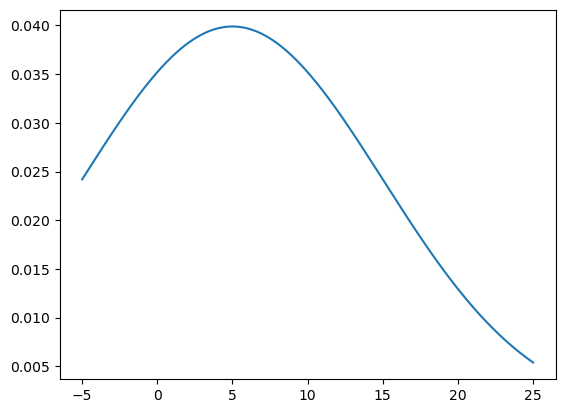

In [37]:
player = "Dayne Zorko"
mu = np.linspace(-5, 25, num=10000)

# prior
prior_mean = home_player_values[home_player_values['Player'] == player]['exp_vaep_value'].iloc[0]
# prior_std = home_player_values[home_player_values['Player'] == player]['exp_vaep_value'].iloc[0]
prior_std = 10
prior_dist = stats.norm.pdf(mu, loc = prior_mean, scale = prior_std)
# prior_dist = prior_dist/prior_dist.sum()
print((prior_mean, prior_std))
plt.plot(mu, prior_dist)


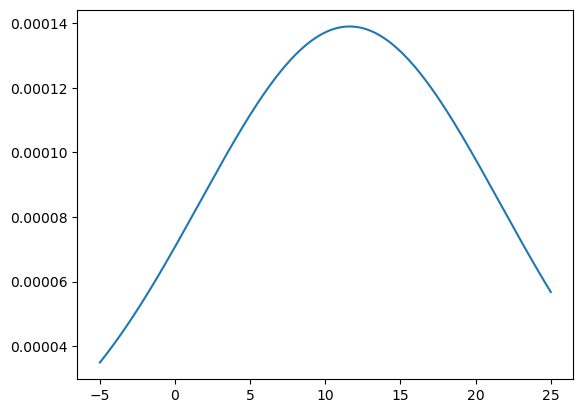

In [38]:
# likelihood
actual_value = home_player_values[home_player_values['Player'] == player]['actual_exp_vaep_value'].iloc[0]
def likelihood_func(data, mu, sigma):
    likelihood_out = stats.norm.pdf(data, mu, scale=sigma)
    return likelihood_out / likelihood_out.sum()

likelihood_out = likelihood_func(actual_value, mu, prior_std)

plt.plot(mu, likelihood_out)

8.463487502323355e-05 1.0


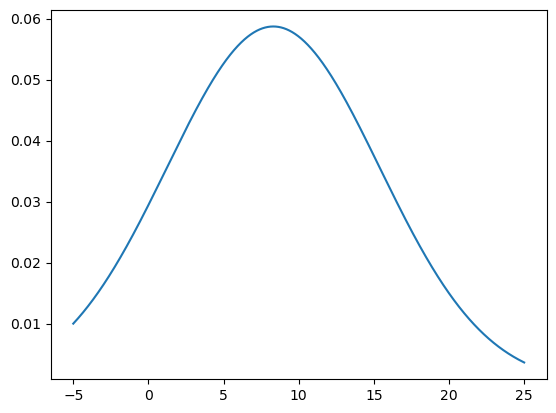

In [39]:
# evidence
unnormalized_posterior = likelihood_out * prior_dist
p_data = sp.integrate.trapz(unnormalized_posterior, mu)
normalized_posterior = unnormalized_posterior / p_data
print(sp.integrate.trapz(unnormalized_posterior, mu), sp.integrate.trapz(normalized_posterior, mu))
plt.plot(mu, normalized_posterior)

In [40]:
prior_mean, prior_std

(5, 10)

In [41]:
posterior_mean = (((1/prior_std)*prior_mean) + ((1/prior_std)*actual_value)) / ((1/prior_std) + (1/prior_std))
# posterior_std = (prior_std*prior_std)/(prior_std+prior_std)
posterior_std = prior_std
posterior_mean, posterior_std

(8.3083869337, 10)

Repeat for Dayne Zorko

In [128]:
def run_bayesian_simulation(player_stats, starting_mean, starting_std):
    
    match_list = ["Initial"]
    prior_list = [starting_mean]
    posterior_list = [starting_mean]
    std_list = [starting_std]
    actual_list = [0]
    counter = 0
    for index, row in player_stats.iterrows():
        match_list.append(row['Match_ID'])
        # print(row['Match_ID'])
        prior_mean = prior_list[counter]
        # prior_std = std_list[counter-1]
        # print("Prior mean: {}".format(prior_mean))
        # print("Prior std: {}".format(prior_std))
        # print(std_list)
        
        match_actual_value = row['exp_vaep_value']
        # print("Match value: {}".format(match_actual_value))
        
        # posterior_mean = (((1/prior_std)*prior_mean) + ((1/prior_std)*match_actual_value)) / ((1/prior_std) + (1/prior_std))
        posterior_mean = (1.5*(prior_std**2)*prior_mean + 0.5*(prior_std**2)*match_actual_value) / (prior_std**2 + prior_std**2)
        posterior_std = prior_std
        # posterior_std = (prior_std*prior_std)/(prior_std+prior_std)

        # print("Posterior mean: {}".format(posterior_mean))
        # print("Posterior std: {}".format(posterior_std))    
        prior_list.append(posterior_list[counter])
        actual_list.append(match_actual_value)
        posterior_list.append(posterior_mean)
        # std_list.append(posterior_std)
        
        counter += 1
        
    ratings_data = pd.DataFrame.from_dict({
        'Match_ID' : match_list,
        "Prior" : prior_list,
        'Actual' : actual_list,
        'Posterior' : posterior_list,
        # "Std" : std_list,
    }
    )
    return ratings_data

In [193]:
player = "Dayne Zorko"
# ratings = player_stats[(player_stats['Player'] == player) & (player_stats['Season'] == 2021)]
ratings = player_stats[(player_stats['Player'] == player)]
run_bayesian_simulation(ratings, 0, 10)

,Match_ID,Prior,Actual,Posterior
0,Initial,0.0000,0.0000,0.0000
1,202101_BrisbaneLions_Sydney,0.0000,11.6168,2.9042
2,202102_Geelong_BrisbaneLions,2.9042,8.0030,2.0007
3,202103_Collingwood_BrisbaneLions,2.0007,8.5494,4.3155
4,202104_WesternBulldogs_BrisbaneLions,4.3155,4.4195,2.6054
5,202105_BrisbaneLions_Essendon,2.6054,5.1031,4.5124
6,202106_Carlton_BrisbaneLions,4.5124,14.7764,5.6482
7,202107_BrisbaneLions_PortAdelaide,5.6482,4.8791,4.6041
8,202108_BrisbaneLions_Fremantle,4.6041,11.0987,7.0108
9,202109_GoldCoast_BrisbaneLions,7.0108,15.7889,7.4003


In [147]:
def calculate_posterior(prior_mean, actual, prior_std=10, prior_weight = 1):
        
    return (prior_weight*(prior_std**2)*prior_mean + (2-prior_weight)*(prior_std**2)*actual) / (prior_std**2 + prior_std**2)

In [166]:
home_team = match_player_stats[match_player_stats['Team'] == match_player_stats['Home_Team']][['Match_ID', 'Player', 'Team', 'Home_Team', 'exp_vaep_value']]
home_team['prior'] = 0
home_team['posterior'] = calculate_posterior(prior_mean=home_team['prior'], actual=home_team['exp_vaep_value'], prior_std=10, prior_weight = 1.5)
print(home_team['prior'].sum(), home_team['exp_vaep_value'].sum(), home_team['posterior'].sum())
home_team

0 100.57023532925001 25.142558832312503


,Match_ID,Player,Team,Home_Team,exp_vaep_value,prior,posterior
0,202101_BrisbaneLions_Sydney,Brandon Starcevich,Brisbane Lions,Brisbane Lions,3.3626,0,0.8407
1,202101_BrisbaneLions_Sydney,Callum Ah Chee,Brisbane Lions,Brisbane Lions,1.3190,0,0.3297
2,202101_BrisbaneLions_Sydney,Charlie Cameron,Brisbane Lions,Brisbane Lions,6.0347,0,1.5087
3,202101_BrisbaneLions_Sydney,Daniel Rich,Brisbane Lions,Brisbane Lions,-0.7593,0,-0.1898
4,202101_BrisbaneLions_Sydney,Dayne Zorko,Brisbane Lions,Brisbane Lions,11.6168,0,2.9042
5,202101_BrisbaneLions_Sydney,Eric Hipwood,Brisbane Lions,Brisbane Lions,3.3529,0,0.8382
6,202101_BrisbaneLions_Sydney,Grant Birchall,Brisbane Lions,Brisbane Lions,0.2492,0,0.0623
7,202101_BrisbaneLions_Sydney,Harris Andrews,Brisbane Lions,Brisbane Lions,7.5671,0,1.8918
8,202101_BrisbaneLions_Sydney,Harry Sharp,Brisbane Lions,Brisbane Lions,1.0034,0,0.2508
9,202101_BrisbaneLions_Sydney,Hugh McCluggage,Brisbane Lions,Brisbane Lions,3.6323,0,0.9081


In [167]:
away_team = match_player_stats[match_player_stats['Team'] != match_player_stats['Home_Team']][['Match_ID', 'Player', 'Team', 'Home_Team', 'exp_vaep_value']]
away_team['prior'] = 0
away_team['posterior'] = calculate_posterior(prior_mean=away_team['prior'], actual=away_team['exp_vaep_value'], prior_std=10, prior_weight = 1.5)
away_team['prior'].sum(), away_team['exp_vaep_value'].sum(), away_team['posterior'].sum(), 

(0, 121.0789253783, 30.269731344575)

In [168]:
team = "Brisbane Lions"
team_player_stats = player_stats[player_stats['Team'] == team]
match_list = list(team_player_stats['Match_ID'].unique())
for match_id in match_list:
    
team_player_stats

,Match_ID,Team,Player,Round_ID,AFL_API_Player_ID,Player_Type,playerId,Age,Height,Weight,Number,Kicking_Foot,State_Of_Origin,Draft_Year,Debut_Year,Recruited_From,Draft_Position,Draft_Type,Photo_URL,Date_Of_Birth,Percent_Played,Behinds,Bounces,Centre_Bounces_Attended,Centre_Clearances,Clangers,Defensive_Contest_Losses,Defensive_Contest_Loss_Percentage,Defensive_One_On_One_Contests,Contested_Marks,Contested_Possession_Rate,Contested_Possessions,Offensive_One_On_One_Contests,Offensive_Contest_Wins,Offensive_Contest_Win_Percentage,Defensive_Half_Pressure_Acts,Disposal_Efficiency,Disposals,AFL_Fantasy_Points,Effective_Disposals,Effective_Kicks,Inside_50_Ground_Ball_Gets,Frees_Against,Frees_For,Goal_Accuracy,Goal_Assists,Goals,Ground_Ball_Gets,Handballs,Hit_Outs,Hit_Outs_To_Advantage,Hit_Outs_To_Advantage_Rate,Hit_Out_Win_Percentage,Inside_50s,Intercept_Marks,Intercepts,Kick_Efficiency,Kick_Ins,Kick_Ins_Played_On,Kicks,Kick_To_Handball_Ratio,Marks,Marks_Inside_50,Marks_On_Lead,Metres_Gained,One_Percenters,Pressure_Acts,Player_Rating_Points,Rebound_50s,Ruck_Contests,Score_Involvements,Score_Launches,Shots_At_Goal,Spoils,Stoppage_Clearances,Tackles,Tackles_Inside_50,Clearances,Possessions,Turnovers,Uncontested_Possessions,AFLCA_Player_ID,Coaches_Votes,Position,Team_Status,Position_Sub_Group,Position_Group,Year,Brownlow_Votes,Season,xScore,xT_created,xT_denied,vaep_value,offensive_value,defensive_value,exp_vaep_value,exp_offensive_value,exp_defensive_value,xT_received,xT_prevented,vaep_value_received,exp_vaep_value_received,Player_Season,Score,xScore_Diff,Home_Team,Away_Team,Opponent,Round,Round_str,Round_ID_num
0,202101_BrisbaneLions_Sydney,Brisbane Lions,Brandon Starcevich,202101,Brandon_Starcevich,MEDIUM_DEFENDER,CD_I1002401,22,187,92,37,RIGHT,WA,2017.0,2018.0,Mt Lawley-Inglewood (WA)/Trinity Coll (WA)/Eas...,18.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1999-07-24,84.0,0.0,1.0,0.0,0.0,1.0,1.0,100.0,1.0,1.0,55.6,5.0,0.0,0.0,0.0,4.0,88.9,9.0,31.0,8.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,83.3,0.0,0.0,6.0,2.0,2.0,0.0,1.0,172.0,1.0,5.0,6.1,2.0,0.0,4.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,2.0,4.0,NaN,NaN,Half Back Flank Left,FINAL_TEAM,Half-Back,Back,2021.0,0.0,2021,0.0000,-0.2357,0.0000,0.7115,0.0265,0.6850,3.3626,0.5851,2.7775,-0.4613,0.1906,0.3299,2.3287,Brandon Starcevich_2021,0.0,0.0000,Brisbane Lions,Sydney,Sydney,1,01,20211
1,202101_BrisbaneLions_Sydney,Brisbane Lions,Callum Ah Chee,202101,Callum_Ah_Chee,MEDIUM_DEFENDER,CD_I298437,24,183,79,4,RIGHT,WA,2015.0,2016.0,Kelmscott (WA)/South Fremantle (WAFL)/Gold Coast,8.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1997-10-09,87.0,0.0,0.0,0.0,0.0,4.0,1.0,100.0,1.0,0.0,66.7,8.0,0.0,0.0,0.0,5.0,83.3,12.0,36.0,10.0,5.0,0.0,2.0,0.0,0.0,1.0,0.0,8.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,83.3,1.0,1.0,6.0,1.0,0.0,0.0,0.0,258.0,2.0,7.0,8.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,3.0,1.0,0.0,12.0,6.0,4.0,NaN,NaN,Interchange,FINAL_TEAM,Interchange,Interchange,2021.0,0.0,2021,0.0000,-0.0760,0.0109,0.2915,0.4800,-0.1885,1.3190,1.0314,0.2875,-0.4879,-0.0397,0.6082,3.2690,Callum Ah Chee_2021,0.0,0.0000,Brisbane Lions,Sydney,Sydney,1,01,20211
2,202101_BrisbaneLions_Sydney,Brisbane Lions,Charlie Cameron,202101,Charlie_Cameron,MEDIUM_FORWARD,CD_I990609,27,180,75,23,RIGHT,WA,2014.0,2014.0,Newman Saints (WA)/Swan Districts (WAFL)/Adelaide,NaN,rookieElevation,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1994-07-05,77.0,0.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,50.0,5.0,0.0,0.0,0.0,3.0,70.0,10.0,39.0,7.0,4.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,57.1,0.0,0.0,7.0,2.3,2.0,1.0,2.0,207.0,1.0,9.0,10.1,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,10.0,0.0,5.0,NaN,NaN,Forward Pocket Right,FINAL_TEAM,Forward-Pocket,Forward,2021.0,0.0,2021,0.0000,0.4603,-0.1664,0.6968,0.6813,0.0155,6.0347,5.8826,0.1521,0.1979,-0.0355,0.8599,8.1863,Charlie Cameron_2021,0.0,0.0000,Brisbane Lions,Sydney,Sydney,1,01,20211
3,202101_BrisbaneLions_Sydney,Brisbane Lions,Daniel Ri

In [145]:
def compute_percentile(parameter_values, distribution_values, percentile=0.5):
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return parameter_values[percentile_index]

In [ ]:
compute_percentile(mu, prior_dist, percentile=0.5)

In [ ]:
compute_percentile(mu, normalized_posterior, percentile=0.5)

In [ ]:
plt.plot(mu, normalized_posterior, label = 'Final Posterior Model')
plt.axvline(x = compute_percentile(mu, normalized_posterior, 0.005), ls = '--', color = 'y', label = '99% Conf Int')
plt.axvline(x = compute_percentile(mu, normalized_posterior, 0.995), ls = '--', color = 'y')
plt.plot(mu, prior_dist)
plt.legend()